In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import os
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load
data = pd.read_csv('./train_data.csv')
data.head()

,Unnamed: 0,имя,возраст,пол,тип_региона_проживания,тип_обслуживания,дата_регистрации,реферальная_ссылка,устройство,последний_визит,дней_с_момента_последнего_логина,среднее_время,средний_чек,частота_посещений,баллы,скидки,жалобы,статус_жалобы,фидбек,риск_ухода
0,0,Lucio Gabriel,49,F,Town,Basic Membership,2015-08-07,Yes,Smartphone,02:17:14,23,47.450000,41083.45,29.0,657.67,No,Yes,Solved,Poor Product Quality,5
1,1,Shaina Taube,57,M,NaN,Gold Membership,2015-05-14,Yes,Desktop,21:25:14,19,826.085388,34196.17,21.0,701.51,Yes,No,Not Applicable,Poor Customer Service,4
2,2,Maryln Roger,37,M,Town,Silver Membership,2017-03-14,No,Desktop,10:23:23,6,145.450000,26744.56,Error,715.44,Yes,Yes,No Information Available,Poor Customer Service,4
3,3,Alaina Densmore,23,F,City,Silver Membership,2015-09-25,Yes,?,00:03:10,20,170.090000,18016.81,18.0,743.10,Yes,Yes,No Information Available,Too many ads,3
4,4,Bernadine Krasner,30,M,NaN,Premium Membership,2016-12-13,Yes,Both,08:54:23,14,715.040000,17044.98,17.0,717.35,Yes,No,Not Applicable,Too many ads,3


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29593 entries, 0 to 29592
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        29593 non-null  int64  
 1   имя                               29593 non-null  object 
 2   возраст                           29593 non-null  int64  
 3   пол                               29593 non-null  object 
 4   тип_региона_проживания            25235 non-null  object 
 5   тип_обслуживания                  29593 non-null  object 
 6   дата_регистрации                  29593 non-null  object 
 7   реферальная_ссылка                29593 non-null  object 
 8   устройство                        29593 non-null  object 
 9   последний_визит                   29593 non-null  object 
 10  дней_с_момента_последнего_логина  29593 non-null  int64  
 11  среднее_время                     29593 non-null  float64
 12  сред

In [ ]:
# create new feature from datetime data['дата_регистрации']
import datetime
date_fixed = pd.to_datetime(data['дата_регистрации'], errors='coerce')
month = date_fixed.dt.month
tdelta = np.datetime64(datetime.datetime.now()) - date_fixed
data['days_since_reg'] = tdelta.dt.days

In [ ]:
time_fixed_visit = pd.to_datetime(data['последний_визит'], errors='coerce')
data['last_visit_hour'] = time_fixed_visit.dt.hour

In [ ]:
data

,Unnamed: 0,имя,возраст,пол,тип_региона_проживания,тип_обслуживания,дата_регистрации,реферальная_ссылка,устройство,последний_визит,дней_с_момента_последнего_логина,среднее_время,средний_чек,частота_посещений,баллы,скидки,жалобы,статус_жалобы,фидбек,риск_ухода,days_since_reg,last_visit_hour
0,0,Lucio Gabriel,49,F,Town,Basic Membership,2015-08-07,Yes,Smartphone,02:17:14,23,47.450000,41083.45,29.0,657.67,No,Yes,Solved,Poor Product Quality,5,2067,2
1,1,Shaina Taube,57,M,NaN,Gold Membership,2015-05-14,Yes,Desktop,21:25:14,19,826.085388,34196.17,21.0,701.51,Yes,No,Not Applicable,Poor Customer Service,4,2152,21
2,2,Maryln Roger,37,M,Town,Silver Membership,2017-03-14,No,Desktop,10:23:23,6,145.450000,26744.56,Error,715.44,Yes,Yes,No Information Available,Poor Customer Service,4,1482,10
3,3,Alaina Densmore,23,F,City,Silver Membership,2015-09-25,Yes,?,00:03:10,20,170.090000,18016.81,18.0,743.10,Yes,Yes,No Information Available,Too many ads,3,2018,0
4,4,Bernadine Krasner,30,M,NaN,Premium Membership,2016-12-13,Yes,Both,08:54:23,14,715.040000,17044.98,17.0,717.35,Yes,No,Not Applicable,Too many ads,3,1573,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29588,29588,Margarito Mcmunn,22,F,Town,Premium Membership,2015-09-11,Yes,?,16:41:20,-999,203.870000,16189.73,6.0,776.87,No,Yes,No Information Available,No reason specified,3,2032,16
29589,29589,Zoe Iskra,20,F,City,Premium Membership,2017-07-17,Yes,Desktop,03:02:22,16,126.310000,9631.66,21.0,759.54,Yes,Yes,Solved,Poor Customer Service,3,1357,3
29590,29590,Flavia Kosak,60,F,Town,Silver Membership,2017-02-20,Yes,Smartphone,03:14:36,10,737.530000,39931.79,14.0,768.84,Yes,No,Not Applicable,User Friendly Website,2,1504,3
29591,29591,Afton Bingham,53,M,City,Basic Membership,2017-08-17,No,Both,22:41:51,8,258.650000,3605.02,5.0,642.85,Yes,Yes,Unsolved,Poor Customer Service,4,1326,22


In [ ]:
y = data.iloc[:,19]
#drop cols
data = data.drop(data.columns[[0, 1, 6, 9]],axis=1)

In [ ]:
data['тип_региона_проживания'] = data['тип_региона_проживания'].replace(np.nan, '')
data['баллы'] = data['баллы'].replace(np.nan, 0)

In [ ]:
data.head()

,возраст,пол,тип_региона_проживания,тип_обслуживания,реферальная_ссылка,устройство,дней_с_момента_последнего_логина,среднее_время,средний_чек,частота_посещений,баллы,скидки,жалобы,статус_жалобы,фидбек,риск_ухода
0,49,F,Town,Basic Membership,Yes,Smartphone,23,47.450000,41083.45,29.0,657.67,No,Yes,Solved,Poor Product Quality,5
1,57,M,,Gold Membership,Yes,Desktop,19,826.085388,34196.17,21.0,701.51,Yes,No,Not Applicable,Poor Customer Service,4
2,37,M,Town,Silver Membership,No,Desktop,6,145.450000,26744.56,15.9987,715.44,Yes,Yes,No Information Available,Poor Customer Service,4
3,23,F,City,Silver Membership,Yes,?,20,170.090000,18016.81,18.0,743.10,Yes,Yes,No Information Available,Too many ads,3
4,30,M,,Premium Membership,Yes,Both,14,715.040000,17044.98,17.0,717.35,Yes,No,Not Applicable,Too many ads,3


In [ ]:
# analyse
data.describe()

,возраст,дней_с_момента_последнего_логина,среднее_время,средний_чек,баллы,риск_ухода,days_since_reg,last_visit_hour
count,29593.000000,29593.000000,29593.000000,29593.000000,29593.000000,29593.000000,29593.000000,29593.000000
mean,37.143480,-42.015612,243.855711,29241.813315,622.878172,3.460109,1732.942892,11.523502
std,15.875275,229.010624,398.904701,19372.163387,273.381956,1.413534,317.145319,6.905294
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,-1.000000,1190.000000,0.000000
25%,23.000000,8.000000,60.300000,14278.490000,574.460000,3.000000,1458.000000,6.000000
50%,37.000000,12.000000,161.410000,27510.120000,680.020000,4.000000,1731.000000,12.000000
75%,51.000000,16.000000,355.820000,40785.460000,757.620000,5.000000,2008.000000,17.000000
max,64.000000,26.000000,3235.578521,99914.050000,1816.933696,5.000000,2285.000000,23.000000


In [ ]:
# Пустых нет
np.where(data.applymap(lambda x: x == ' '))

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
# Заменим на среднее:
data_vf = data['частота_посещений'].replace('Error', np.nan)
data_vf = data_vf.dropna()
data_vf1 = pd.to_numeric(data_vf)
mean_ = data_vf1.mean()
data['частота_посещений'] = data['частота_посещений'].replace('Error', mean_)

In [ ]:
cat_cols = [
    'пол',
    'тип_региона_проживания',
    'тип_обслуживания',
    'реферальная_ссылка',
    'устройство',
    'скидки',
    'жалобы',
    'статус_жалобы',
    'фидбек',
]
num_cols = [
            'возраст',
            'дней_с_момента_последнего_логина',
            'среднее_время',
            'средний_чек',
            'частота_посещений',
            'баллы',
]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f91296e0e90>,
      dtype=object)

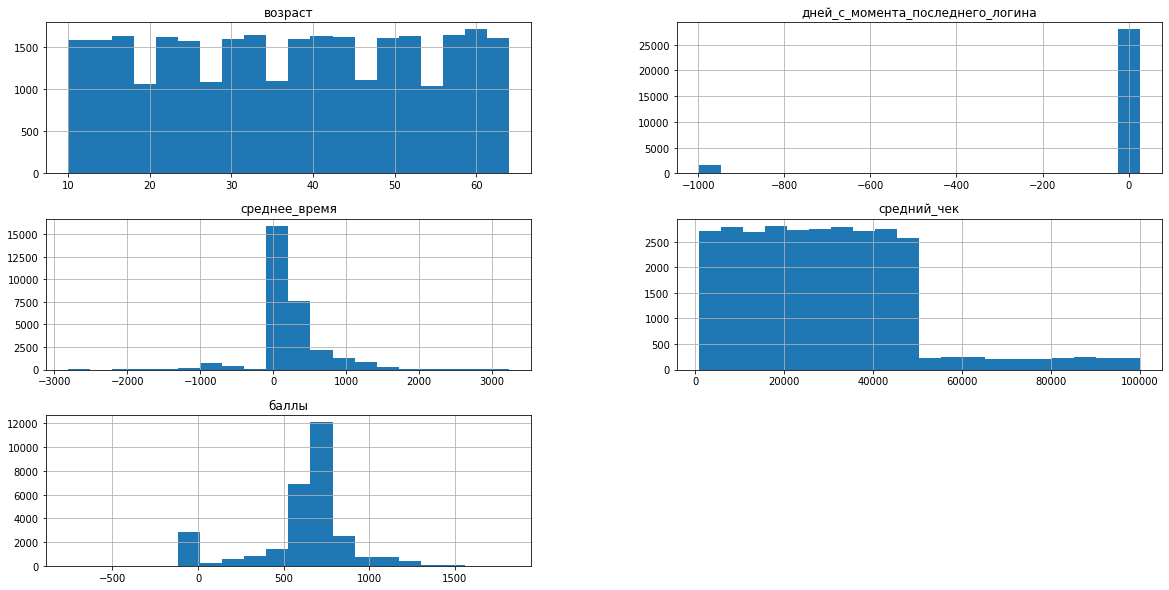

In [ ]:
data[['возраст', 'дней_с_момента_последнего_логина', 'среднее_время', 'средний_чек','частота_посещений', 'баллы']].hist(bins=20, figsize=(20, 10))

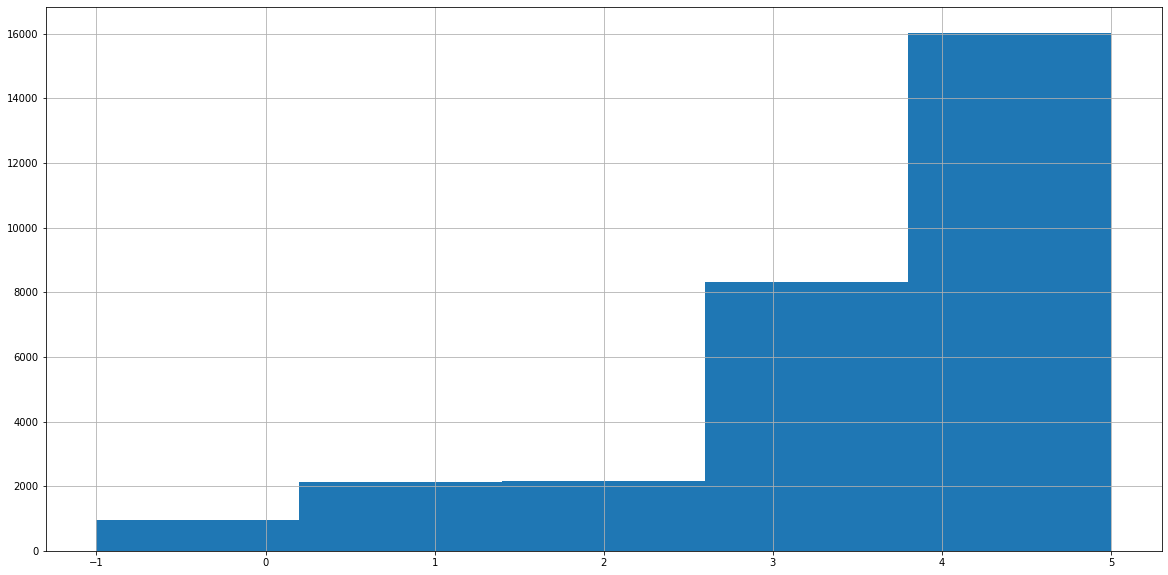

In [ ]:
data['риск_ухода'].hist(bins=5)

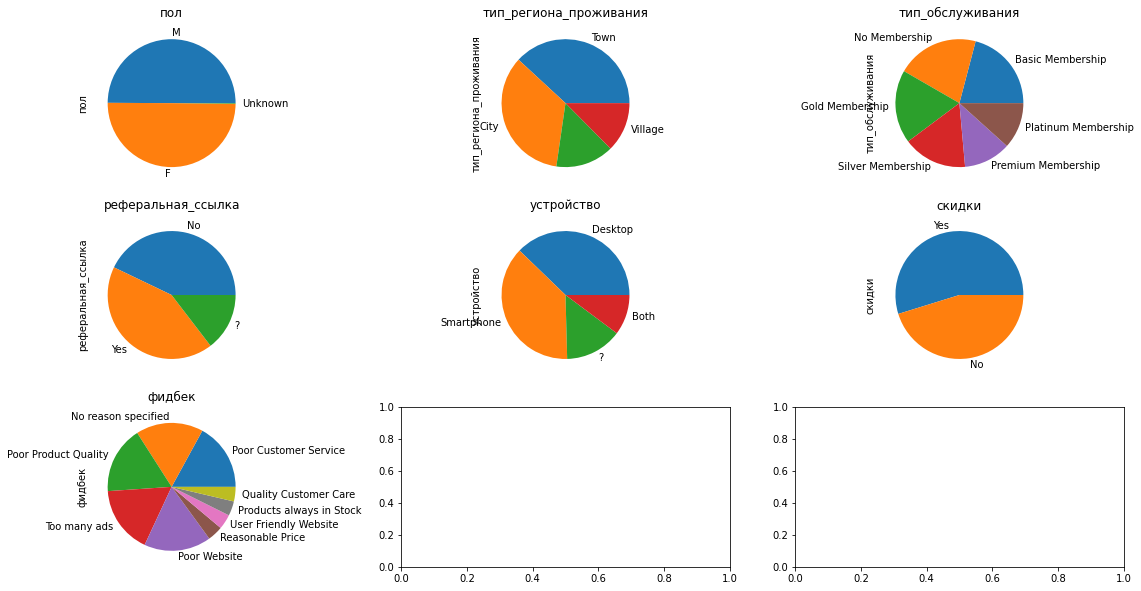

In [ ]:
# PIE PLOTS:
fig, axes = plt.subplots(figsize=(20, 10), nrows=3, ncols=3)
data['пол'].value_counts().plot.pie(ax=axes[0,0]).title.set_text('пол')
data['тип_региона_проживания'].value_counts().plot.pie(ax=axes[0,1]).title.set_text('тип_региона_проживания')
data['тип_обслуживания'].value_counts().plot.pie(ax=axes[0,2]).title.set_text('тип_обслуживания')
data['реферальная_ссылка'].value_counts().plot.pie(ax=axes[1,0]).title.set_text('реферальная_ссылка')
data['устройство'].value_counts().plot.pie(ax=axes[1,1]).title.set_text('устройство')
data['скидки'].value_counts().plot.pie(ax=axes[1,2]).title.set_text('скидки')
data['фидбек'].value_counts().plot.pie(ax=axes[2,0]).title.set_text('фидбек')


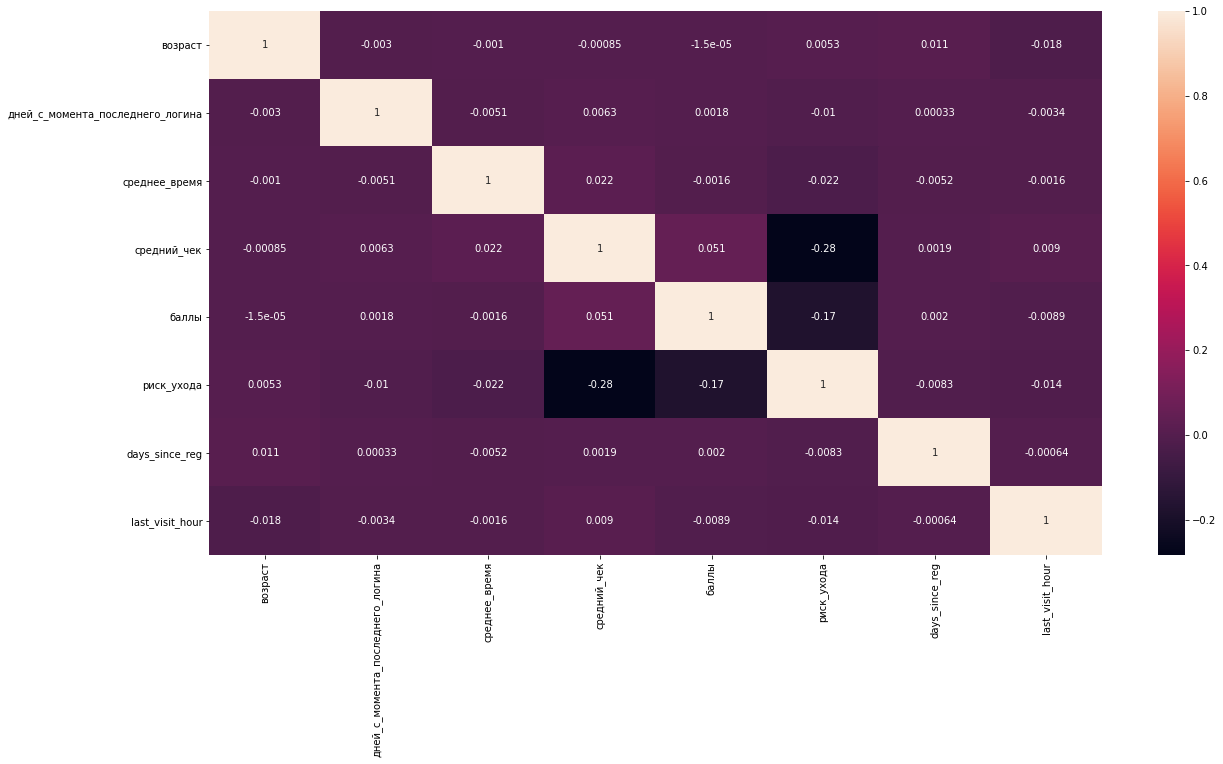

In [ ]:
# корр матрица для числовых признаков
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
cat_cols1 = [
    'пол',
    'тип_региона_проживания',
    'тип_обслуживания',
    'реферальная_ссылка',
    'устройство',
    'скидки',
    'жалобы',
    'статус_жалобы',
    'фидбек',
]
# copy
dfc = data.copy()
encoder = LabelEncoder()
dfc[cat_cols1] = dfc[cat_cols1].apply(encoder.fit_transform)

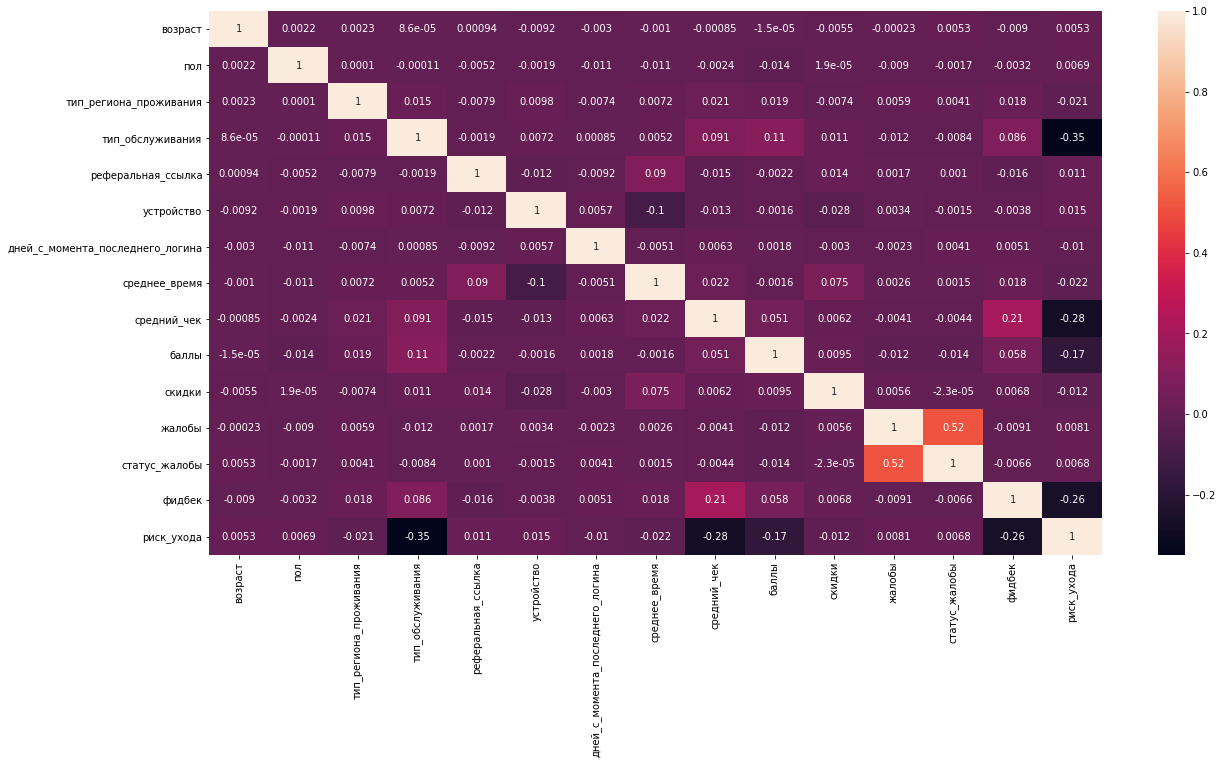

In [ ]:
# корр матрица
corrMatrix = dfc.corr()
sns.heatmap(corrMatrix, annot=True)
plt.rcParams["figure.figsize"] = (20,10)

In [ ]:
dfc.corr(method='pearson')

,возраст,пол,тип_региона_проживания,тип_обслуживания,реферальная_ссылка,устройство,дней_с_момента_последнего_логина,среднее_время,средний_чек,баллы,скидки,жалобы,статус_жалобы,фидбек,риск_ухода
возраст,1.000000,0.002158,0.002284,0.000086,0.000939,-0.009151,-0.002986,-0.000999,-0.000848,-0.000015,-0.005508,-0.000232,0.005310,-0.009036,0.005309
пол,0.002158,1.000000,0.000103,-0.000113,-0.005172,-0.001897,-0.010716,-0.010619,-0.002413,-0.014026,0.000019,-0.009010,-0.001666,-0.003157,0.006947
тип_региона_проживания,0.002284,0.000103,1.000000,0.014572,-0.007904,0.009825,-0.007407,0.007218,0.020536,0.018595,-0.007406,0.005900,0.004142,0.018313,-0.021154
тип_обслуживания,0.000086,-0.000113,0.014572,1.000000,-0.001908,0.007202,0.000846,0.005177,0.090693,0.112481,0.011154,-0.011630,-0.008381,0.085567,-0.349069
реферальная_ссылка,0.000939,-0.005172,-0.007904,-0.001908,1.000000,-0.012024,-0.009179,0.090172,-0.014964,-0.002189,0.014484,0.001696,0.001042,-0.015664,0.010956
устройство,-0.009151,-0.001897,0.009825,0.007202,-0.012024,1.000000,0.005737,-0.104320,-0.012734,-0.001629,-0.027996,0.003438,-0.001549,-0.003777,0.014821
дней_с_момента_последнего_логина,-0.002986,-0.010716,-0.007407,0.000846,-0.009179,0.005737,1.000000,-0.005086,0.006311,0.001831,-0.002999,-0.002291,0.004117,0.005121,-0.010316
среднее_время,-0.000999,-0.010619,0.007218,0.005177,0.090172,-0.104320,-0.005086,1.000000,0.022438,-0.001616,0.075285,0.002590,0.001450,0.017906,-0.021965
средний_чек,-0.000848,-0.002413,0.020536,0.090693,-0.014964,-0.012734,0.006311,0.022438,1.000000,0.051044,0.006180,-0.004059,-0.004411,0.207813,-0.282057
баллы,-0.000015,-0.014026,0.018595,0.112481,-0.002189,-0.001629,0.001831,-0.001616,0.051044,1.000000,0.009508,-0.011874,-0.014024,0.058327,-0.173198


In [ ]:
# split
y = data['риск_ухода']
X = data.drop('риск_ухода', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=43, shuffle=True)

In [ ]:
# model
model = CatBoostRegressor(eval_metric='RMSE', random_seed=666)
model.fit(X_train, y_train, cat_features=cat_cols, verbose=0)

In [ ]:
# predict
y_preds = model.predict(X_test)
print(mean_squared_error(y_test, y_preds)) # 0.8562568341689898
# with 2 datetime feature: 0.8509372886343486 0.8536121492087481

0.8536121492087481


In [ ]:
def search_cat_boost_params():
    params = {'depth':[6,4,7,10],
              'iterations':[250,100,500,1000],
              'learning_rate':[0.03,0.1,0.2,0.3],
              'l2_leaf_reg':[3,1,5,10]}
    model6 = CatBoostRegressor(cat_features=cat_cols, eval_metric='RMSE', random_seed=666)
    grid_search_result = model6.grid_search(params,
                                           X=X_train,
                                           y=y_train,
                                           cv=3,
                                           partition_random_seed=3,
                                           stratified=True,
                                       )
    return grid_search_result
  
# found_parameters = search_cat_boost_params() # Поиск параметров
# print(found_parameters['params']) # grid_search_result['cv_results']

Streaming output truncated to the last 5000 lines.
527:	learn: 0.3606769	test: 0.9453577	best: 0.8934482 (34)	total: 52.7s	remaining: 47.1s
528:	learn: 0.3597198	test: 0.9453922	best: 0.8934482 (34)	total: 52.8s	remaining: 47s
529:	learn: 0.3588449	test: 0.9456978	best: 0.8934482 (34)	total: 53s	remaining: 47s
530:	learn: 0.3579598	test: 0.9456693	best: 0.8934482 (34)	total: 53.1s	remaining: 46.9s
531:	learn: 0.3577708	test: 0.9457390	best: 0.8934482 (34)	total: 53.2s	remaining: 46.8s
532:	learn: 0.3567955	test: 0.9456194	best: 0.8934482 (34)	total: 53.3s	remaining: 46.7s
533:	learn: 0.3548782	test: 0.9457653	best: 0.8934482 (34)	total: 53.4s	remaining: 46.6s
534:	learn: 0.3542607	test: 0.9458523	best: 0.8934482 (34)	total: 53.5s	remaining: 46.5s
535:	learn: 0.3537654	test: 0.9456986	best: 0.8934482 (34)	total: 53.6s	remaining: 46.4s
536:	learn: 0.3535091	test: 0.9456928	best: 0.8934482 (34)	total: 53.7s	remaining: 46.3s
537:	learn: 0.3533184	test: 0.9456456	best: 0.8934482 (34)	total:

In [ ]:
with open("cb_params.txt", "w") as text_file:
    text_file.write(str(found_parameters['params']))

In [ ]:
# fit new model with found parameters
# {'depth': 7, 'l2_leaf_reg': 10, 'iterations': 500, 'learning_rate': 0.03}
model6 = CatBoostRegressor(eval_metric='RMSE', random_seed=666, depth=7, l2_leaf_reg=10, iterations=500, learning_rate=0.03)
model6.fit(X_train, y_train, cat_features=cat_cols, verbose=0)

y_preds = model6.predict(X_test)
print(mean_squared_error(y_test, y_preds)) # 0.8517970273997116 0.851395079972883

0.8517970273997116


In [ ]:
# Clean and process test data
X_test_f = pd.read_csv('test_data.csv')
X_test_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7399 entries, 0 to 7398
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        7399 non-null   int64  
 1   имя                               7399 non-null   object 
 2   возраст                           7399 non-null   int64  
 3   пол                               7399 non-null   object 
 4   тип_региона_проживания            6329 non-null   object 
 5   тип_обслуживания                  7399 non-null   object 
 6   дата_регистрации                  7399 non-null   object 
 7   реферальная_ссылка                7399 non-null   object 
 8   устройство                        7399 non-null   object 
 9   последний_визит                   7399 non-null   object 
 10  дней_с_момента_последнего_логина  7399 non-null   int64  
 11  среднее_время                     7399 non-null   float64
 12  средни

In [ ]:
# create new feature from datetime data['дата_регистрации']
import datetime
date_fixed = pd.to_datetime(X_test_f['дата_регистрации'], errors='coerce')
month = date_fixed.dt.month
tdelta = np.datetime64(datetime.datetime.now()) - date_fixed
X_test_f['days_since_reg'] = tdelta.dt.days

time_fixed_visit = pd.to_datetime(X_test_f['последний_визит'], errors='coerce')
X_test_f['last_visit_hour'] = time_fixed_visit.dt.hour

In [ ]:
X_test_f = X_test_f.drop(X_test_f.columns[[0, 1, 6, 9]],axis=1)

X_test_f['тип_региона_проживания'] = X_test_f['тип_региона_проживания'].replace(np.nan, '')
X_test_f['баллы'] = X_test_f['баллы'].replace(np.nan, 0)

# Заменим на среднее:
data_vf = X_test_f['частота_посещений'].replace('Error', np.nan)
data_vf = data_vf.dropna()
data_vf1 = pd.to_numeric(data_vf)
mean_ = data_vf1.mean()
X_test_f['частота_посещений'] = X_test_f['частота_посещений'].replace('Error', mean_)


In [ ]:
# predict test_data
prediction = model.predict(X_test_f)

In [ ]:
# save csv sumbit

import pandas as pd
df = pd.DataFrame(prediction, columns=['churn_risk_score'])
df.to_csv('preds.csv', index=False)